In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
Image_width = 128
Image_height = 128
Image_size = (Image_width,Image_height)
Image_channles = 3

In [3]:
filenames = os.listdir("./dogs-vs-cats/train")
categories = []
for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

        
df = pd.DataFrame({'filename':filenames, 'category':categories})

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [5]:
model = Sequential()

In [6]:
model.add(Conv2D(32,(3,3),activation = 'relu', input_shape = (Image_width,Image_height,Image_channles)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size =(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'rmsprop', metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [9]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [10]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dogs-vs-cats/train/",x_col='filename',y_col='category',
                                                 target_size=Image_size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [33]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 614s 461ms/step - loss: 0.7025 - accuracy: 0.6387 - val_loss: 0.5303 - val_accuracy: 0.7469
Epoch 2/10
1333/1333 [==============================] - 511s 383ms/step - loss: 0.5507 - accuracy: 0.7289 - val_loss: 0.5162 - val_accuracy: 0.7578
Epoch 3/10
1333/1333 [==============================] - 505s 379ms/step - loss: 0.5062 - accuracy: 0.7563 - val_loss: 1.1567 - val_accuracy: 0.5818
Epoch 4/10
1333/1333 [==============================] - 497s 373ms/step - loss: 0.4687 - accuracy: 0.7815 - val_loss: 0.4387 - val_accuracy: 0.8132
Epoch 5/10
1333/1333 [==============================] - 498s 373ms/step - loss: 0.4398 - accuracy: 0.7969 - val_loss: 0.8842 - val_accuracy: 0.6741
Epoch 6/10
1333/1333 [==============================] - 532s 399ms/step - loss: 0.4143 - accuracy: 0.8145 - val_loss: 0.6484 - val_accuracy: 0.6775

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
1333/1333 [=========

In [34]:
model.save("model1_catsVSdogs_10epoch.h5")

In [11]:
test_filenames = os.listdir("./dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [12]:
from keras.models import load_model

In [13]:
model = load_model('model1_catsVSdogs_10epoch.h5')

In [15]:
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
test_generator = train_datagen.flow_from_directory("./dogs-vs-cats/",classes=['test1'],
                                                 target_size=Image_size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [16]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/home/leeladhar/.local/lib/python3.8/site-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [17]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

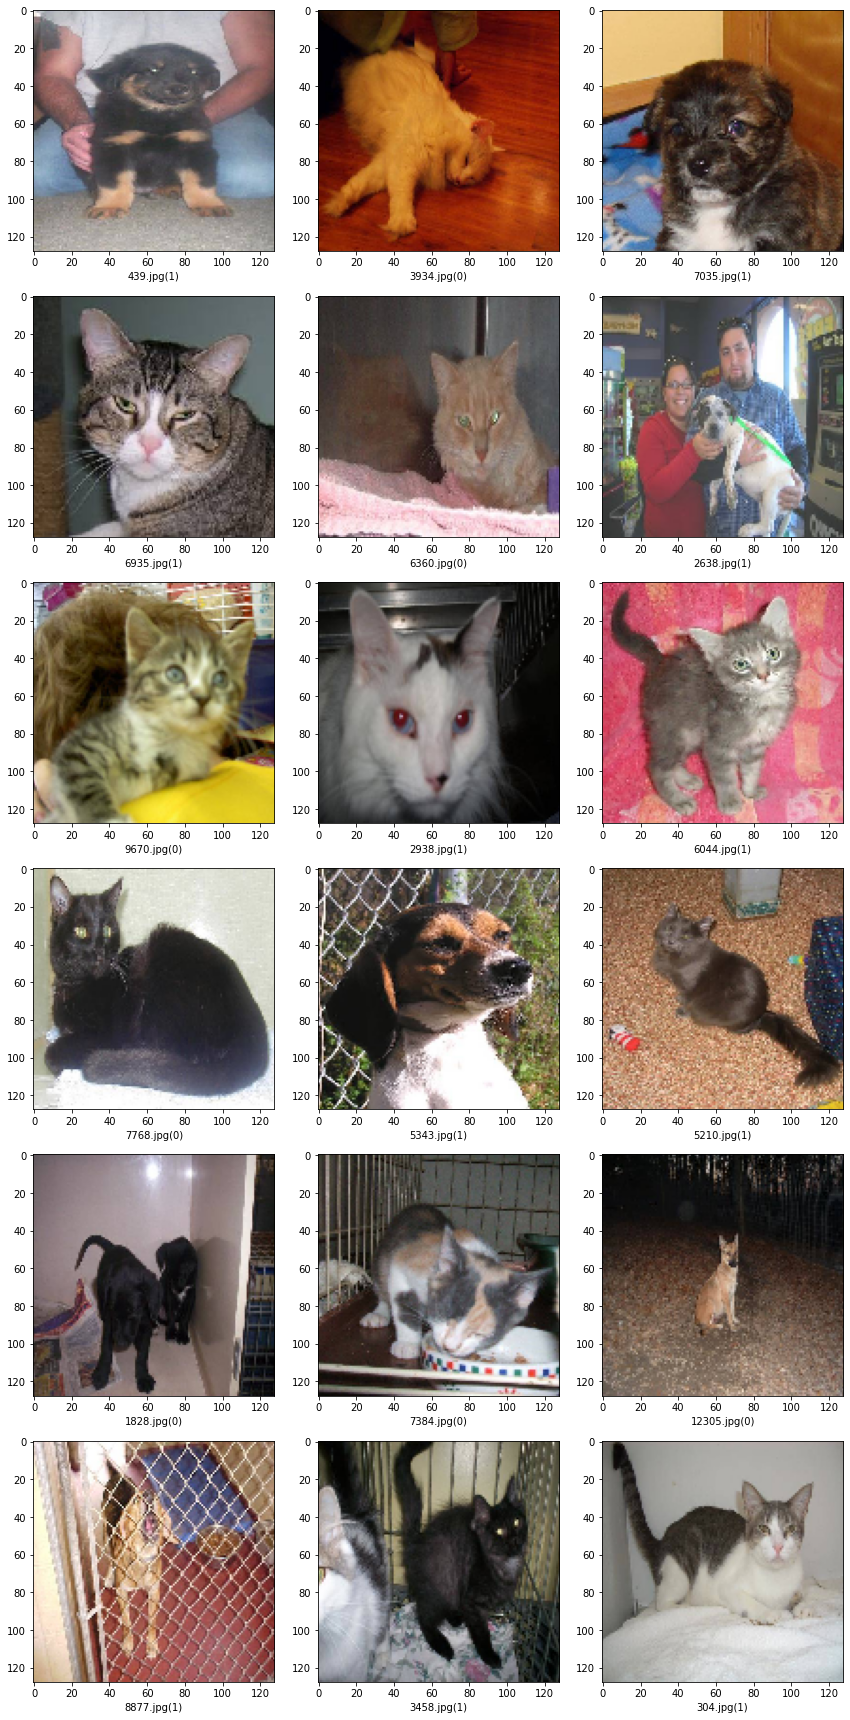

In [19]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dogs-vs-cats/test1/"+filename, target_size=Image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()